# Analyse et classification de posts Reddit provenant de Subreddit sur l'autisme

- Configuration & import

In [85]:
# Import librairies needed for this project
import warnings
warnings.filterwarnings("ignore")

from utils.authentification_token import string_connection
from sqlalchemy import create_engine
import psycopg2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

import gc

import nltk
nltk.download("stopwords")
from utils.nlp_utils_autism import remove_stopwords, normalize_corpus, plot_top_words
import sklearn
from sklearn.feature_extraction.text import  TfidfVectorizer

from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from gensim.corpora.dictionary import Dictionary
from gensim.models import Nmf
from gensim.models.coherencemodel import CoherenceModel

import mlflow

[nltk_data] Downloading package stopwords to /home/cecile/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [86]:
# Configuration display

sklearn.set_config(display="diagram")

## 1) Nettoyage

Les données utilisées sont stockées dans une base de données PostgreSQL. On va donc se connecter à la table de la base de données en utilisant SQLAlchemy et Psycopg2. Une fois la connexion établie, on pourra utiliser Pandas pour mettre nos données dans un dataFrame.

In [87]:
STRING_CONNECTION = string_connection
engine = create_engine(STRING_CONNECTION)

In [88]:
df = pd.read_sql("reddit_extraction", 
                 con=engine)
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism
1,3,You only accept it as long as it doesn’t incon...,1085,13gyesp,https://i.redd.it/doeb5enynqza1.jpg,48,None,Autism
2,4,Yeah basically.,434,13gxkud,https://i.redd.it/vkm7vfz1hqza1.jpg,8,None,Autism
3,5,"""i feel like neurotypical people actually enjo...",807,13gsoty,https://i.redd.it/yc7a52r8ynza1.png,37,None,Autism
4,6,"Or, if I have different colors, I have to eat ...",425,13gxlkt,https://i.redd.it/lai29qz7hqza1.jpg,16,None,Autism


On va supprimer les posts doublons en se basant sur la colonne "id" qui contient un identifiant unique pour chaque post. On va ensuite supprimer les valeurs manquantes. 

In [89]:
df.drop_duplicates('id',
                   inplace=True)

In [90]:
df.dropna(inplace=True, 
          how="any")
df.shape

(11243, 8)

## 2) Analyse de données

L'analyse de données sera divisée en deux grandes parties : 
- une partie sur les données chiffrées. Elles sont peu nombreuses mais peuvent permettre de définir des critères d'exclusion de posts si besoin.
- une partie sur les données textuelles. Cette analyse nous permettra d'avoir une idée du contenu des posts mais aussi de voir les mots qui peuvent être considérés comme des stopwords dans notre cas spécifiques.

### a) Analyse quantitative

L'analyse quantitative contient une analyse univariée du score et du nombre de réponses sur chaque post. Ensuite, une analyse bivariée portant sur la corrélation entre le score et le nombre de réponse a été réalisé. 
Ces différentes analyses permettent de définir le profil d'un post moyen avec son nombre moyen et médian de commentaires et de son score.

#### Analyse univariée

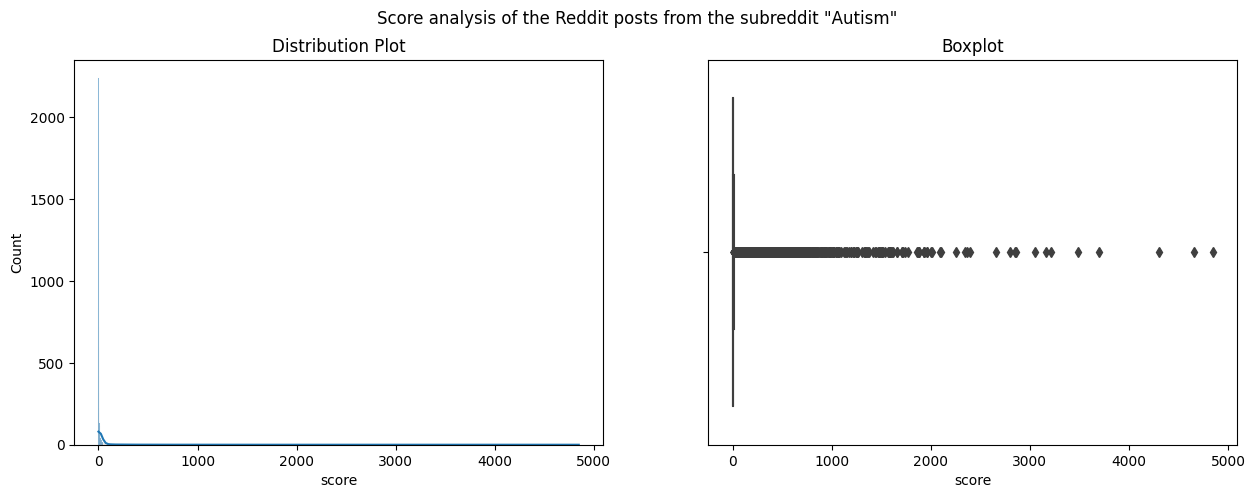

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Score analysis of the Reddit posts from the subreddit "Autism"')

sns.histplot(ax=axes[0], x="score", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="score", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [92]:
print("Mean score:", (np.mean(df["score"])).round(2))
print("Median score:", np.median(df["score"]))

Mean score: 41.73
Median score: 3.0


Le score médian est de 3 alors que le score moyen est de 41.73. 

On observe une grande différence entre le score moyen et le score médian. Si on choisit le score comme critère d'exclusion, il serait donc intéressant de conserver les posts avec un score minimum de 3. 

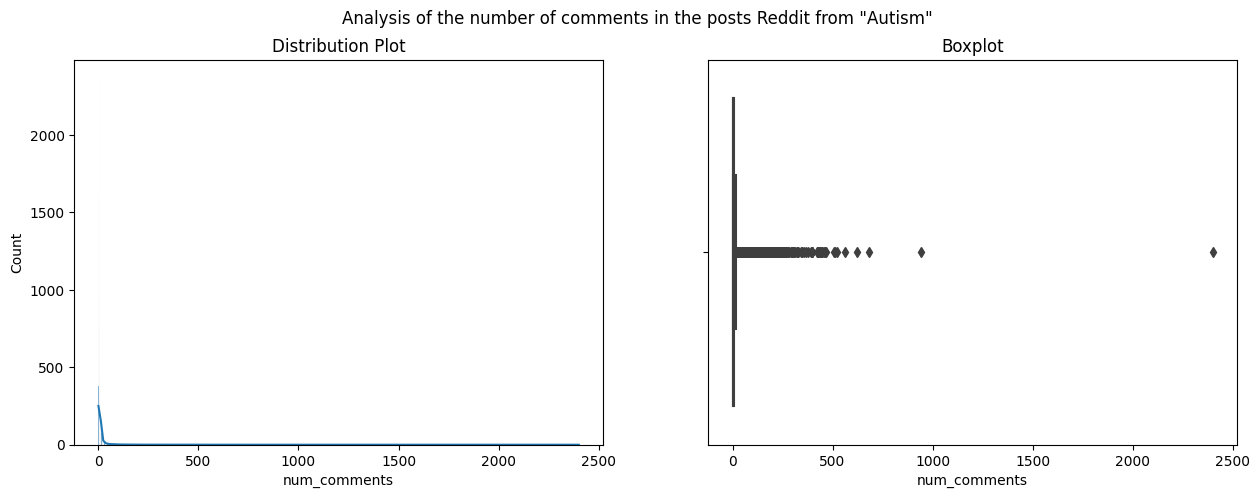

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Analysis of the number of comments in the posts Reddit from "Autism"')

sns.histplot(ax=axes[0], x="num_comments", data=df, kde=True)
axes[0].set_title("Distribution Plot")

sns.boxplot(ax=axes[1], x="num_comments", data=df)
axes[1].set_title("Boxplot")

plt.show()

In [94]:
print("Mean number of comments: ", (np.mean(df["num_comments"]).round(2)))
print("Median number of comments: ", np.median(df["num_comments"]))

Mean number of comments:  12.77
Median number of comments:  3.0


Le nombre de réponse médian est de 3 alors que le nombre de réponse moyen est de 12.37.

Comme pour le score, le nombre de réponse médian et le nombre de réponse moyen présente un grand écart. Il serait donc intéressant de conserver les posts avec un nombre de réponse égale ou supérieur à 3.

#### Analyse bivariée

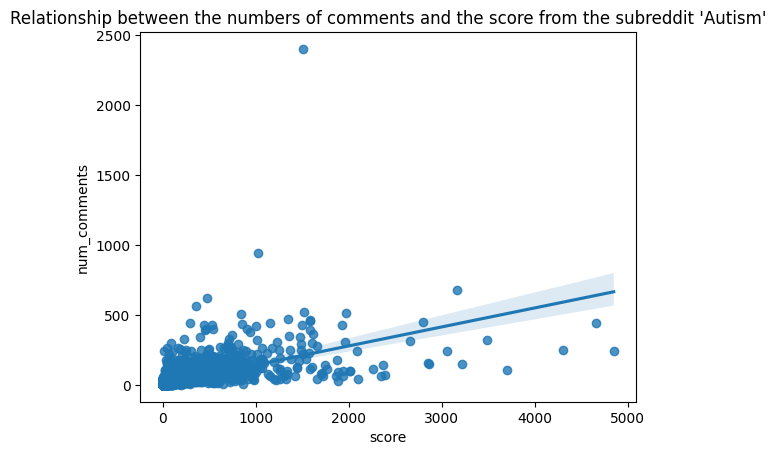

In [95]:
sns.regplot(x="score",
            y="num_comments",
            data=df)
plt.title("Relationship between the numbers of comments and the score from the subreddit 'Autism'")
plt.show()

In [96]:
print("Correlation coefficient:", round(np.corrcoef(df["num_comments"], df["score"])[0,1], 3))

Correlation coefficient: 0.613


- Suppression des posts

In [97]:
ind = df.loc[(df["num_comments"] <= 3) & (df["score"] <= 3)].index.to_list()
df.drop(index = ind, 
        inplace = True)

In [98]:
df.shape

(7087, 8)

### b) Analyse textuelle

#### Analyse du contenu des titres

In [99]:
df_title = df[["id","title"]]
df_title.head()

,id,title
0,13h5ymk,"Dear *those* autistic men,"
6,13h6s7n,I am a server. I waited on someone with autism...
7,13h3c1h,"The Love of my life, while on the spectrum…"
9,13h3wzn,DJing has been a great way for me to share one...
10,13gpg1j,It makes me extremely angry that we don’t have...


In [100]:
df_title["title_norm"] = normalize_corpus(df_title["title"])
df_title.head()

,id,title,title_norm
0,13h5ymk,"Dear *those* autistic men,",dear man
6,13h6s7n,I am a server. I waited on someone with autism...,I server I wait stop
7,13h3c1h,"The Love of my life, while on the spectrum…",love life
9,13h3wzn,DJing has been a great way for me to share one...,djing great I share special interest stim freely
10,13gpg1j,It makes me extremely angry that we don’t have...,I extremely angry male sa statistic


In [101]:
vectorizer_tf = TfidfVectorizer()

tfidf_title = vectorizer_tf.fit_transform(df_title['title_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.mean(), columns=["Value"])
df_title_tf = df_title_tf.sort_values("Value",ascending=False)
df_title_tf = df_title_tf.head(30)
df_title_tf = df_title_tf.sort_values("Value", ascending=True)

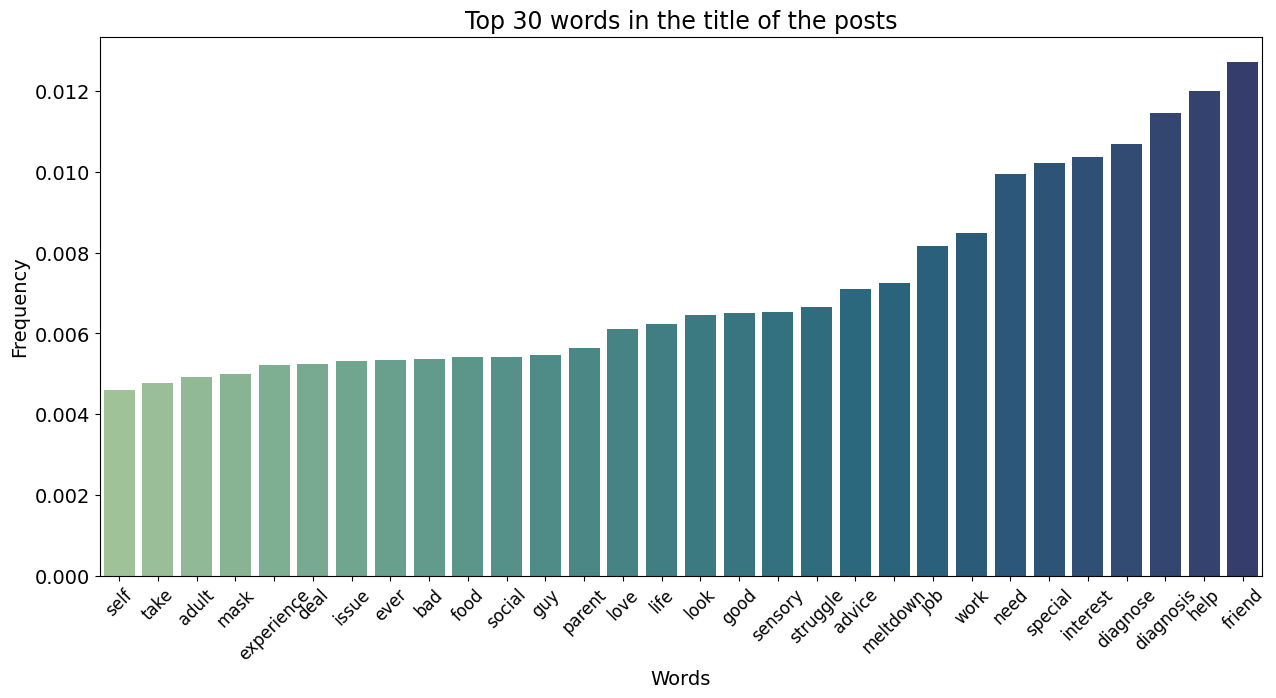

In [102]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_title_tf.index,
    y = df_title_tf["Value"],
    data = df_title_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the title of the posts", fontsize = 17)

plt.show()

#### Analyse du contenu des posts

In [103]:
df_text = df[["id","text"]]

In [104]:
df_text["text_norm"] = normalize_corpus(df_text["text"])
df_text.head()

,id,text,text_norm
0,13h5ymk,Our lives aren't automatically better then you...,life automatically well stuggle girlfriend stu...
6,13h6s7n,I (20M) work at a popular soul food chain in t...,I work popular soul food chain southeast part ...
7,13h3c1h,"Ever since I was 11 years old, I’ve always wan...",ever since I year old I girlfriend yes ik youn...
9,13h3wzn,I have been DJing for about 5 years and am now...,I dj year gig I actually enjoy I share small v...
10,13gpg1j,9/10 Afab autistic people get SAed in their li...,afab saed lifetime I attempt amab statistic si...


In [105]:
vectorizer_tf = TfidfVectorizer()
tfidf_text = vectorizer_tf.fit_transform(df_text['text_norm']).toarray()
feature_names = vectorizer_tf.get_feature_names_out()
df_text_tf = pd.DataFrame(tfidf_text, columns=feature_names)
df_text_tf = pd.DataFrame(df_text_tf.mean(), columns=["Value"])
df_text_tf = df_text_tf.sort_values("Value",ascending=False)
df_text_tf = df_text_tf.head(30)
df_text_tf = df_text_tf.sort_values("Value", ascending = True)

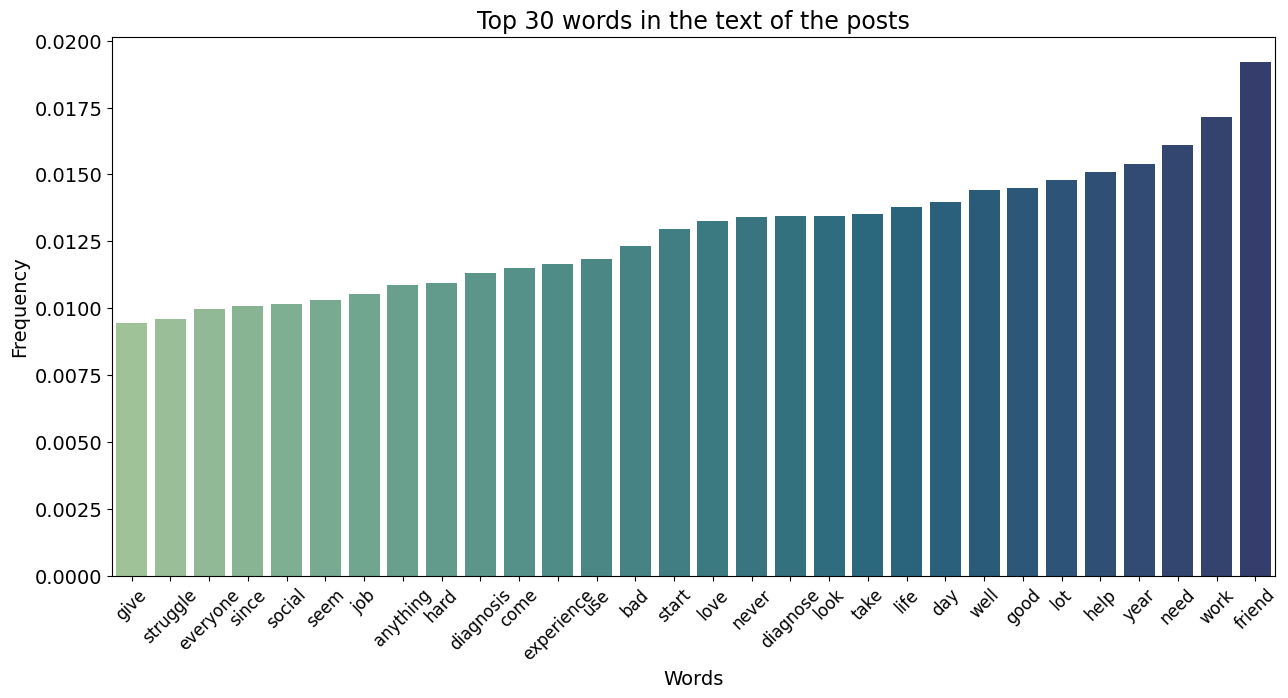

In [106]:
fig = plt.figure(figsize = (15, 7))

g = sns.barplot(
    x = df_text_tf.index,
    y = df_text_tf["Value"],
    data = df_text_tf,
    palette = 'crest'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title("Top 30 words in the text of the posts", fontsize = 17)

plt.show()

## 3) Topic modeling

- Prépartion des données

In [107]:
docs = df_title["title_norm"] + " " + df_text["text_norm"]

In [108]:
docs = docs.values.astype('U')

In [109]:
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [110]:
data_dense = tfidf.todense()
print("Sparsicity: ", (((data_dense > 0).sum()/data_dense.size)*100).round(3), "%")

Sparsicity:  0.239 %


- Modélisation via NMF

In [111]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

In [112]:
topic_nums = list(np.arange(5, 10 + 1, 1))
coherence_scores = []

In [113]:
for num in topic_nums:
    nmf = Nmf(
        corpus = corpus,
        num_topics = num, 
        id2word=common_dictionary,
        chunksize = 2000,
        normalize = True,
        random_state = 42
    )

    cm = CoherenceModel(
        model = nmf,
        texts = dataset,
        dictionary=common_dictionary,
        coherence = 'c_v'
    )

    coherence_scores.append(round(cm.get_coherence(), 5))

In [114]:
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

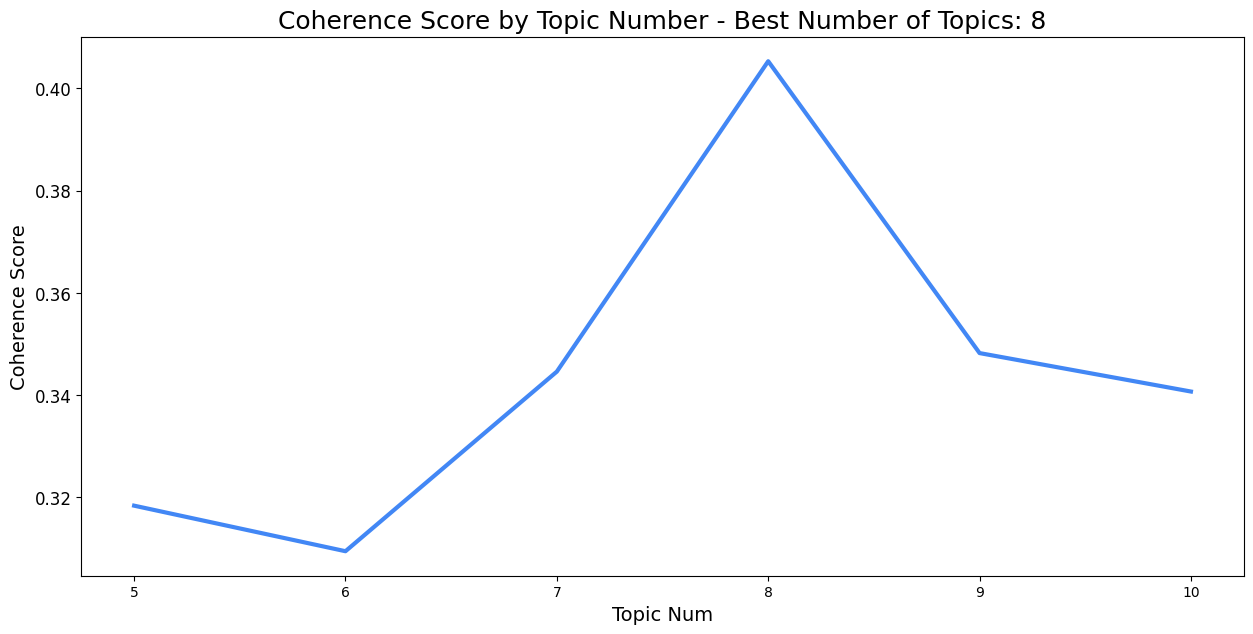

In [115]:
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth = 3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.yticks(fontsize=12)

plt.show()

In [116]:
nmf = NMF(n_components = 8,
          random_state = 42)
nmf.fit(tfidf)

2023/07/05 21:30:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '544b2ab2b7a04a76b301adb43ecc102e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/07/05 21:30:41 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/07/05 21:30:41 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/07/05 21:30:41 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


NMF(n_components=8, random_state=42)

- Visualisation du résultat

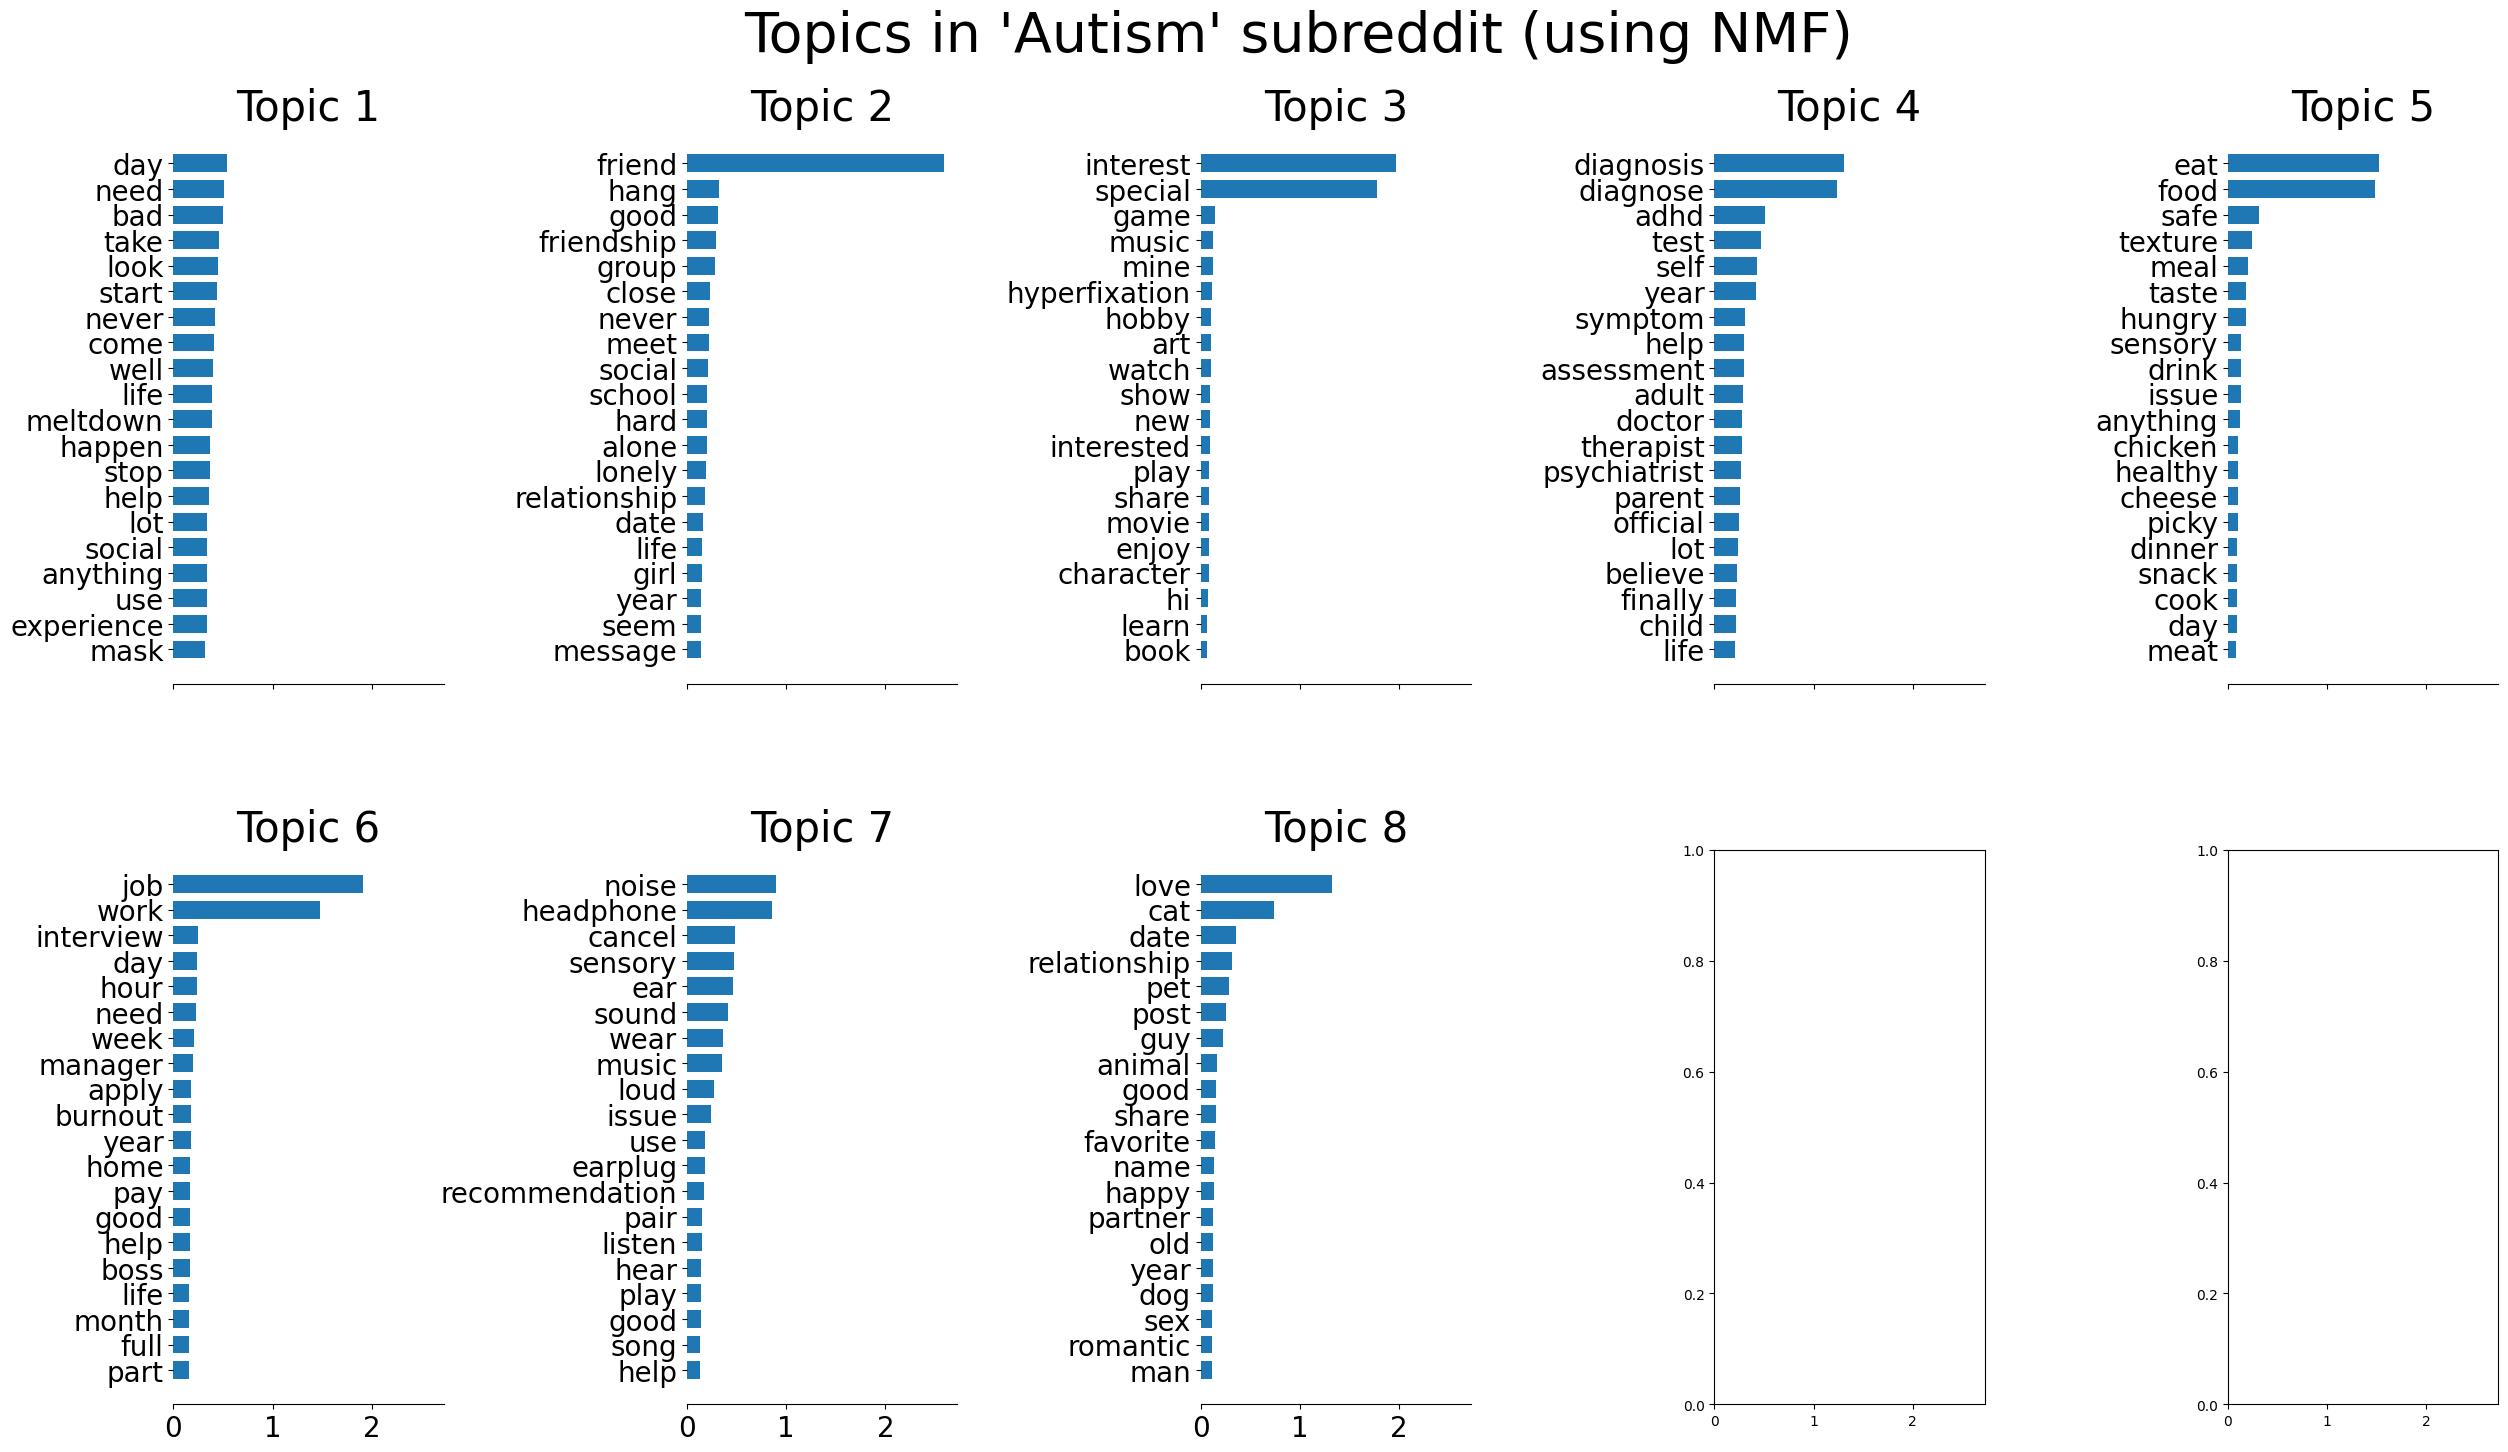

In [117]:
plot_top_words(nmf, 
               tfidf_feature_names, 
               n_top_words = 20, 
               title = "Topics in 'Autism' subreddit (using NMF)")

- Thématique 1 : Vie quotidienne
- Thématique 2 : Amitié
- Thématique 3 : Intérêts spécifiques
- Thématique 4 : Santé
- Thématique 5 : Alimentation
- Thématique 6 : Vie professionnelle
- Thématique 7 : Bruit
- Thématique 8 : Relations intimes

## 4) Etiquettage des données

In [118]:
df["title_&_text_norm"] = df_title["title_norm"] + " " + df_text["text_norm"]

In [119]:
df.head()

,index,title,score,id,url,num_comments,text,subreddit_name,title_&_text_norm
0,2,"Dear *those* autistic men,",345,13h5ymk,https://www.reddit.com/r/autism/comments/13h5y...,123,Our lives aren't automatically better then you...,Autism,dear man life automatically well stuggle girlf...
6,8,I am a server. I waited on someone with autism...,34,13h6s7n,https://www.reddit.com/r/autism/comments/13h6s...,5,I (20M) work at a popular soul food chain in t...,Autism,I server I wait stop I work popular soul food ...
7,9,"The Love of my life, while on the spectrum…",49,13h3c1h,https://i.redd.it/fvtm8ox7vrza1.jpg,2,"Ever since I was 11 years old, I’ve always wan...",Autism,love life ever since I year old I girlfriend y...
9,11,DJing has been a great way for me to share one...,40,13h3wzn,https://v.redd.it/h34jtui61sza1,6,I have been DJing for about 5 years and am now...,Autism,djing great I share special interest stim free...
10,12,It makes me extremely angry that we don’t have...,219,13gpg1j,https://www.reddit.com/r/autism/comments/13gpg...,47,9/10 Afab autistic people get SAed in their li...,Autism,I extremely angry male sa statistic afab saed ...


In [120]:
def topic_table(n_top_words, feature_names, nmf):
  topics = {}
  for i, topic_vec in enumerate(nmf.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [121]:
topic_df = topic_table(5, tfidf_vectorizer.get_feature_names_out(), nmf)

topic_df['Label'] = ['Vie quotidienne', 'Amitié', 
                     'Intérêts spécifiques', 'Santé',
                     'Alimentation', 'Vie professionnelle',
                     'Bruit', 'Relations intimes']
document_weights = nmf.transform(tfidf_vectorizer.transform(df['title_&_text_norm'].astype('U')))

df["Topic_Number"] = document_weights.argmax(axis=1)
df = pd.merge(df, 
              topic_df, 
              left_on='Topic_Number', 
              right_index=True, 
              how='left')

## 5) Classification des posts

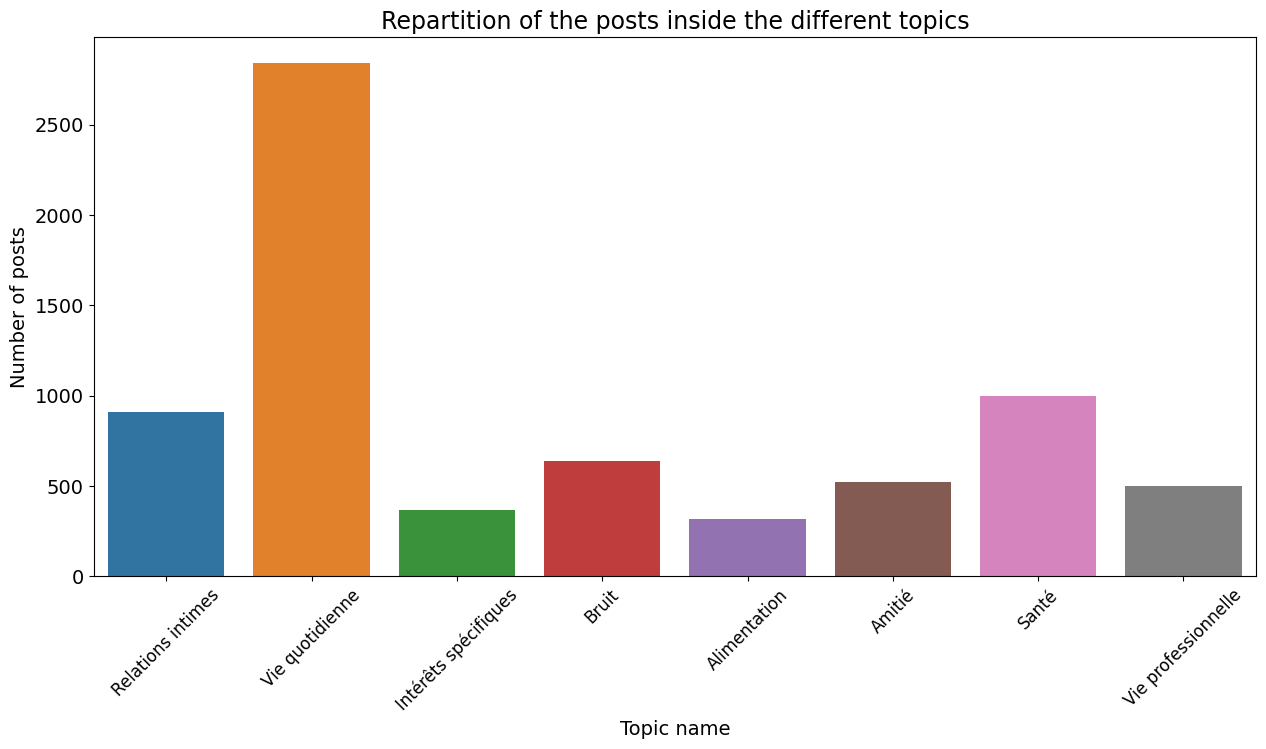

In [122]:
fig = plt.figure(figsize=(15, 7))

g = sns.countplot(x = "Label",
              data = df)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation = 45,
    fontsize = 12)


plt.yticks(fontsize = 14)
plt.xlabel("Topic name",
            fontsize = 14)
plt.ylabel("Number of posts",
           fontsize = 14)
plt.title("Repartition of the posts inside the different topics",
          fontsize = 17)

plt.show()

In [123]:
df.drop(["id", "title", "text", 
         "Top_Topic_Terms", "score",
         "url", "num_comments",
         "subreddit_name", "index"], 
        axis = 1,
        inplace=True)

In [124]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, 
                                     test_size=0.25, 
                                     random_state=42)

y_train = train_set[["Topic_Number"]]
y_test = test_set[["Topic_Number"]]
X_train = train_set.drop(["Label","Topic_Number"], axis = 1)
X_test = test_set.drop(["Label","Topic_Number"], axis = 1)

In [125]:
print(len(X_train),
len(X_test))

5315 1772


In [126]:
print(X_train.head())

                                       title_&_text_norm
11628  awkward encounter buy wine mood ruin awkward e...
14078  samefood saturday I grocery shopping today I I...
11360  I fool mask info diagnose await appointment I ...
9126   selective mutism special interest special inte...
6168   anybody pink meat every I bit pink meat I eat ...


In [127]:
tfidf = TfidfVectorizer()
tfidf.fit(X_train['title_&_text_norm'].astype('U'))
X_train_vec = tfidf.transform(X_train['title_&_text_norm'].astype('U'))
X_test_vec = tfidf.transform(X_test['title_&_text_norm'].astype('U'))

In [128]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("reddit-classifier")

<Experiment: artifact_location='/home/cecile/Documents/Reddit-Analysis/reddit-nlp-analysis/mlruns/1', creation_time=1687610912700, experiment_id='1', last_update_time=1687610912700, lifecycle_stage='active', name='reddit-classifier', tags={}>

In [129]:
mlflow.sklearn.autolog()

with mlflow.start_run():
    mlflow.set_tag("developper", "cecile")
    n_estimators = 200
    mlflow.log_param("n_estimators", n_estimators)
    rf = RandomForestClassifier(n_estimators=n_estimators, 
                                random_state=42)
    rf.fit(X_train_vec, y_train)

    y_pred = rf.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    mlflow.log_metric("accuracy", accuracy)

2023/07/05 21:30:57 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'toarray'
2023/07/05 21:31:12 WARNING mlflow.sklearn.utils: roc_auc_score failed. The metric training_roc_auc will not be recorded. Metric error: too many indices for array: array is 2-dimensional, but 3 were indexed


In [130]:
print("Accuracy Score: ", round(accuracy, 5) * 100, "%")

Accuracy Score:  77.822 %


(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

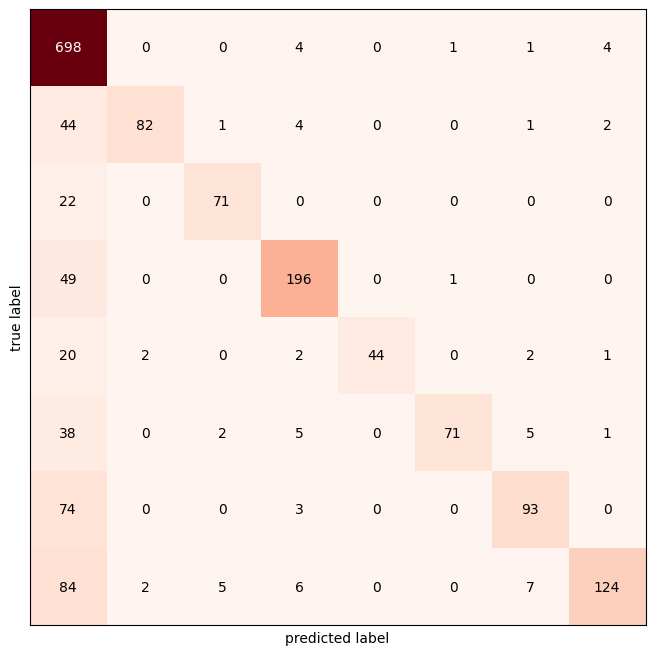

In [131]:
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test,
                      y_pred)
plot_confusion_matrix(cm,
                      figsize = (12,8), 
                      hide_ticks = True,
                      cmap=plt.cm.Reds)